<a href="https://colab.research.google.com/github/Fuad-Khan/2_Class_Religious_Abuse_Models/blob/main/2_class_Religious_Hybrid_Deep_Learning_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BiLSTM + Attention + FastText

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 300)       │     6,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 128)       │       186,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 128)            │           228 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,195,494 (23.63 MB)

 Trainable params: 195,494 (763.65 KB)

 Non-trainable params: 6,000,000 (22.89 MB)

Epoch 1/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 110s 319ms/step - accuracy: 0.7921 - loss: 0.4561 - val_accuracy: 0.8900 - val_loss: 0.2689
Epoch 2/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 139s 312ms/step - accuracy: 0.8953 - loss: 0.2692 - val_accuracy: 0.9015 - val_loss: 0.2463
Epoch 3/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 147s 328ms/step - accuracy: 0.8978 - loss: 0.2593 - val_accuracy: 0.9077 - val_loss: 0.2205
Epoch 4/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 118s 364ms/step - accuracy: 0.9120 - loss: 0.2268 - val_accuracy: 0.9104 - val_loss: 0.2119
Epoch 5/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 129s 322ms/step - accuracy: 0.9136 - loss: 0.2167 - val_accuracy: 0.9193 - val_loss: 0.2046
Epoch 6/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 104s 319ms/step - accuracy: 0.9253 - loss: 0.1946 - val_accuracy: 0.9083 - val_loss: 0.2358
Epoch 7/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 138s 307ms/step - accuracy: 0.9197 - loss: 0.2064 - val_accuracy: 0.9241 - val_loss: 0.1952
Epoch 8/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 143s 310ms/step - accuracy: 0.9287 -

162/162 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step


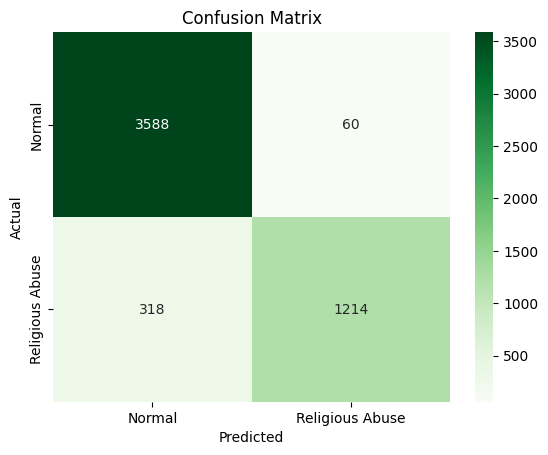

                 precision    recall  f1-score   support

         Normal       0.92      0.98      0.95      3648
Religious Abuse       0.95      0.79      0.87      1532

       accuracy                           0.93      5180
      macro avg       0.94      0.89      0.91      5180
   weighted avg       0.93      0.93      0.92      5180



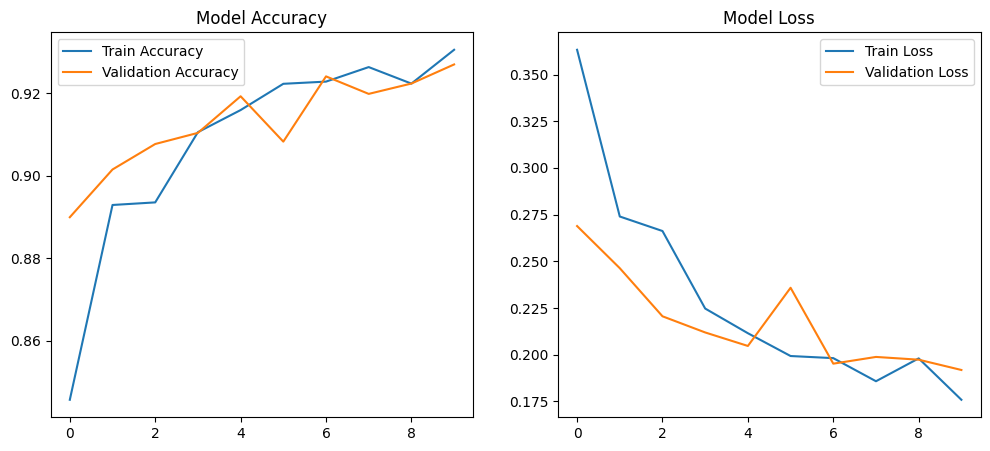

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import requests
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, Layer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
import tensorflow as tf

# Download FastText embeddings (Bangla)
url = "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.bn.300.vec.gz"
filename = "cc.bn.300.vec.gz"
response = requests.get(url)
with open(filename, "wb") as f:
    f.write(response.content)

# Attention Layer
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='att_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        e = K.squeeze(e, axis=-1)
        alpha = K.softmax(e)
        alpha = K.expand_dims(alpha, axis=-1)
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

# Load dataset (2-label dataset only: 0 = Normal, 1 = Religious Abuse)
file_path = "/content/drive/MyDrive/Research Paper/Data Preprocessing/2 Class/Cleaned_Labeled_Religious_Comments_Numeric.csv"
df = pd.read_csv(file_path)
df.dropna(subset=['comment', 'label_numeric'], inplace=True)

texts = df['comment'].astype(str).tolist()
labels = df['label_numeric'].tolist()

# Label Encoding (2 classes)
le = LabelEncoder()
y = to_categorical(le.fit_transform(labels), num_classes=2)

# Tokenization
max_words = 20000
max_len = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
x = pad_sequences(sequences, maxlen=max_len)

# Load FastText Embeddings
embedding_index = {}
with gzip.open(filename, 'rt', encoding='utf8') as f:
    next(f)
    for line in f:
        values = line.rstrip().split(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Embedding Matrix
embedding_dim = 300
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= max_words:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Train/Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Build BiLSTM + Attention Model (2 output classes)
input_ = Input(shape=(max_len,))
embedding = Embedding(input_dim=num_words,
                      output_dim=embedding_dim,
                      weights=[embedding_matrix],
                      input_length=max_len,
                      trainable=False)(input_)
bilstm = Bidirectional(LSTM(64, return_sequences=True))(embedding)
attention = Attention()(bilstm)
drop = Dropout(0.5)(attention)
dense = Dense(64, activation='relu')(drop)
output = Dense(2, activation='softmax')(dense)

model = Model(inputs=input_, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train Model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=64)

# Save Model
model.save("/content/drive/MyDrive/Research Paper/Models/2 Class/Hybrid Deep Learning Models/bilstm_attention_fasttext_bangla_2label.h5")

# Evaluate
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Normal', 'Religious Abuse'],
            yticklabels=['Normal', 'Religious Abuse'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred_classes, target_names=['Normal', 'Religious Abuse']))

# Accuracy & Loss Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()

plt.show()


# CNN + LSTM + GlobalAveragePooling Model

✅ Embeddings loaded for 1468578 words.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 100, 300)       │     3,600,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 96, 64)         │        96,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 48, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 48, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,733,313 (14.24 MB)

 Trainable params: 133,313 (520.75 KB)

 Non-trainable params: 3,600,000 (13.73 MB)

Epoch 1/6
146/146 ━━━━━━━━━━━━━━━━━━━━ 43s 269ms/step - accuracy: 0.6402 - loss: 0.5628 - val_accuracy: 0.9011 - val_loss: 0.2404
Epoch 2/6
146/146 ━━━━━━━━━━━━━━━━━━━━ 37s 257ms/step - accuracy: 0.9033 - loss: 0.2619 - val_accuracy: 0.9069 - val_loss: 0.2425
Epoch 3/6
146/146 ━━━━━━━━━━━━━━━━━━━━ 41s 257ms/step - accuracy: 0.9151 - loss: 0.2134 - val_accuracy: 0.9073 - val_loss: 0.2112
Epoch 4/6
146/146 ━━━━━━━━━━━━━━━━━━━━ 43s 260ms/step - accuracy: 0.9383 - loss: 0.1701 - val_accuracy: 0.9122 - val_loss: 0.2245
Epoch 5/6
146/146 ━━━━━━━━━━━━━━━━━━━━ 37s 253ms/step - accuracy: 0.9504 - loss: 0.1262 - val_accuracy: 0.9073 - val_loss: 0.2076
Epoch 6/6
146/146 ━━━━━━━━━━━━━━━━━━━━ 40s 244ms/step - accuracy: 0.9652 - loss: 0.1014 - val_accuracy: 0.9126 - val_loss: 0.2447
162/162 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step

✅ Classification Report:

                 precision    recall  f1-score   support

         Normal       0.96      0.91      0.93      3648
Religious Abuse       0.81      0.90

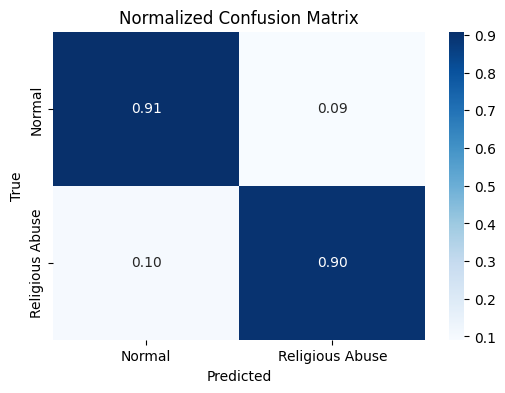

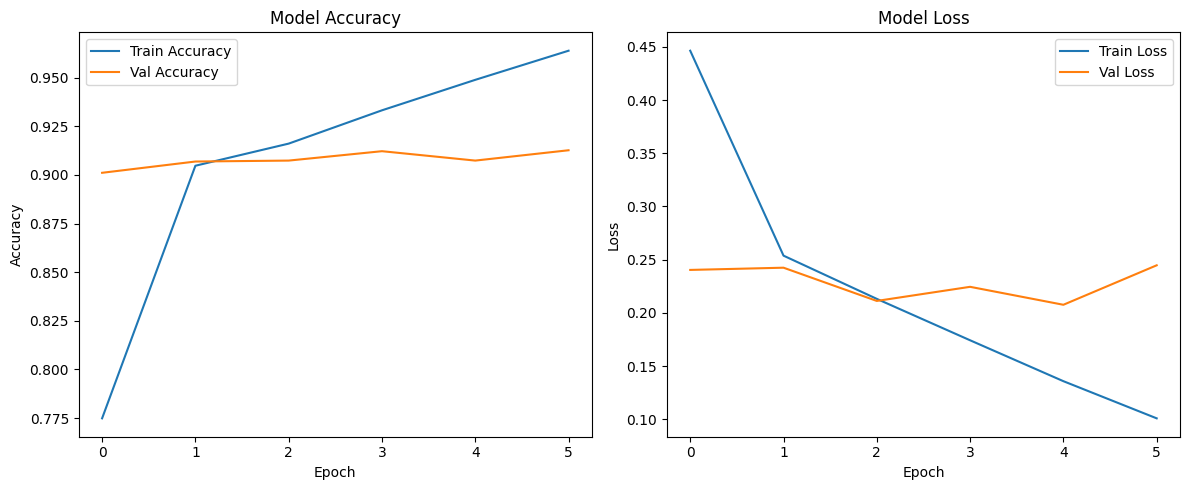


✅ Binary CNN + LSTM model and tokenizer saved.


In [3]:
# STEP 1: Imports
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, Conv1D, MaxPooling1D,
                                     LSTM, Dense, Dropout, GlobalAveragePooling1D)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# STEP 2: Load CSV
file_path = "/content/drive/MyDrive/Research Paper/Data Preprocessing/2 Class/Cleaned_Labeled_Religious_Comments_Numeric.csv"
df = pd.read_csv(file_path)

# STEP 3: Prepare binary label data
df = df[df['label_numeric'].isin([0, 1])]  # Filter to 0 and 1
texts = df['comment'].astype(str).values
labels = df['label_numeric'].astype(int).values

# STEP 4: Tokenization & Padding
vocab_size = 12000
max_length = 100

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=max_length, padding='post')

# STEP 5: Load FastText Bangla Embeddings
!wget -q https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.bn.300.vec.gz

embedding_index = {}
with gzip.open('cc.bn.300.vec.gz', 'rt', encoding='utf-8', newline='\n', errors='ignore') as f:
    next(f)
    for line in f:
        values = line.rstrip().split(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

embedding_dim = 300
word_index = tokenizer.word_index
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

print(f"✅ Embeddings loaded for {len(embedding_index)} words.")

# STEP 6: Train/Test/Validation Split
X_train_full, X_test, y_train_full, y_test = train_test_split(padded, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=42)

# STEP 7: Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))

# STEP 8: Build the Model
inputs = Input(shape=(max_length,))
x = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False)(inputs)
x = Conv1D(64, 5, activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = LSTM(64, return_sequences=True)(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)  # Binary classification

model = Model(inputs, outputs)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# STEP 9: Train the Model
callbacks = [
    EarlyStopping(patience=2, restore_best_weights=True),
    ModelCheckpoint('best_binary_model.keras', save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    epochs=6,
    batch_size=128,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=callbacks
)

# STEP 10: Evaluate
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

print("\n✅ Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Normal", "Religious Abuse"]))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm / cm.sum(axis=1, keepdims=True), annot=True, fmt='.2f', cmap='Blues',
            xticklabels=["Normal", "Religious Abuse"], yticklabels=["Normal", "Religious Abuse"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

# STEP 11: Plot Training History
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# STEP 12: Save Model and Tokenizer
model.save("/content/drive/MyDrive/Research Paper/Models/2 Class/Hybrid Deep Learning Models/binary_cnn_lstm_model.keras")
with open("/content/drive/MyDrive/Research Paper/Models/2 Class/Hybrid Deep Learning Models/binary_cnn_lstm_tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

print("\n✅ Binary CNN + LSTM model and tokenizer saved.")


# CNN + Bi-LSTM + GlobalAveragePooling


✅ Found embeddings for 11313 out of 46506 tokens.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 100, 300)       │     3,600,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 96, 64)         │        96,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 48, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 48, 128)        │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,770,433 (14.38 MB)

 Trainable params: 170,433 (665.75 KB)

 Non-trainable params: 3,600,000 (13.73 MB)

Epoch 1/6
146/146 ━━━━━━━━━━━━━━━━━━━━ 59s 362ms/step - accuracy: 0.6490 - loss: 0.5446 - val_accuracy: 0.8895 - val_loss: 0.2585
Epoch 2/6
146/146 ━━━━━━━━━━━━━━━━━━━━ 50s 339ms/step - accuracy: 0.9004 - loss: 0.2442 - val_accuracy: 0.9136 - val_loss: 0.2090
Epoch 3/6
146/146 ━━━━━━━━━━━━━━━━━━━━ 50s 343ms/step - accuracy: 0.9199 - loss: 0.1983 - val_accuracy: 0.9184 - val_loss: 0.2055
Epoch 4/6
146/146 ━━━━━━━━━━━━━━━━━━━━ 81s 335ms/step - accuracy: 0.9376 - loss: 0.1517 - val_accuracy: 0.9093 - val_loss: 0.2093
Epoch 5/6
146/146 ━━━━━━━━━━━━━━━━━━━━ 83s 344ms/step - accuracy: 0.9571 - loss: 0.1093 - val_accuracy: 0.9131 - val_loss: 0.2556
162/162 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step

✅ Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      3648
           1       0.87      0.86      0.86      1532

    accuracy                           0.92      5180
   macro avg       0.90      0.90      0.90      5180
weighted 

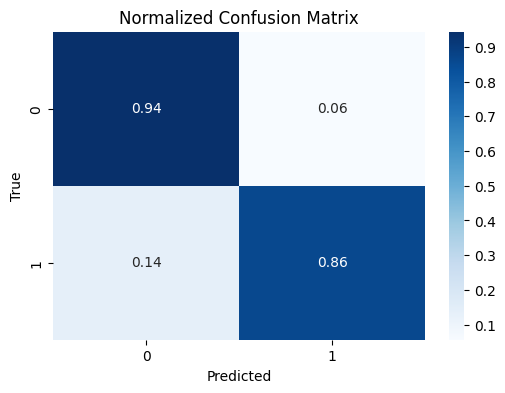

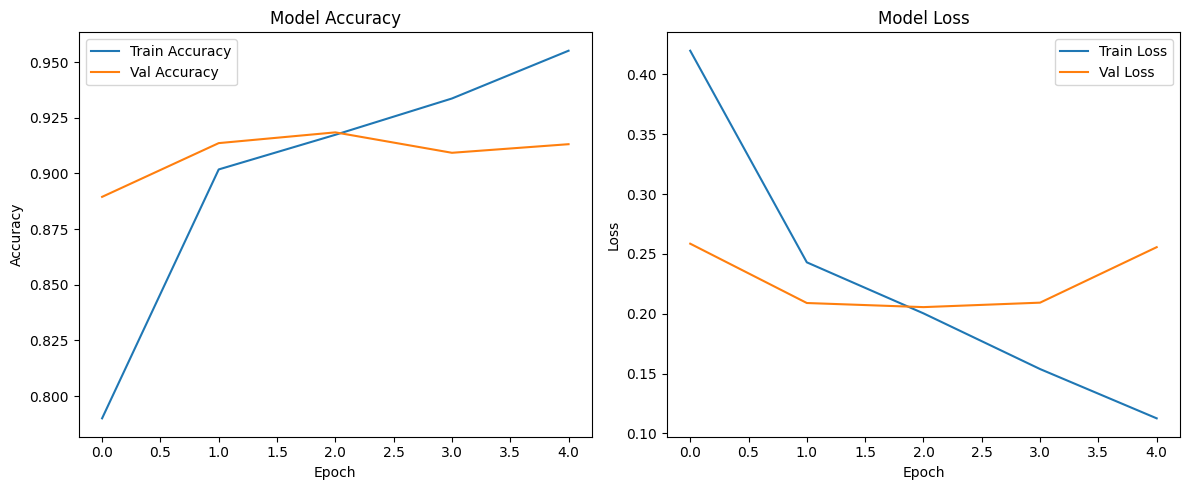


✅ Binary CNN + Bi-LSTM model and tokenizer saved successfully.


In [4]:
# STEP 1: Imports
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, Conv1D, MaxPooling1D,
                                     LSTM, Dense, Dropout, GlobalAveragePooling1D, Bidirectional)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# STEP 2: Load CSV file
file_path = "/content/drive/MyDrive/Research Paper/Data Preprocessing/2 Class/Cleaned_Labeled_Religious_Comments_Numeric.csv"
df = pd.read_csv(file_path)

# STEP 3: Prepare data (BINARY)
texts = df['comment'].astype(str).values
labels = df['label_numeric'].astype(int).values  # 0 or 1 only

# STEP 4: Tokenization & Padding
vocab_size = 12000
max_length = 100

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=max_length, padding='post')

# STEP 5: Load FastText Bangla Embeddings
!wget -q https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.bn.300.vec.gz

embedding_index = {}
with gzip.open('cc.bn.300.vec.gz', 'rt', encoding='utf-8', newline='\n', errors='ignore') as f:
    next(f)
    for line in f:
        values = line.rstrip().split(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

embedding_dim = 300
word_index = tokenizer.word_index
embedding_matrix = np.zeros((vocab_size, embedding_dim))

found = 0
for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            found += 1

print(f"✅ Found embeddings for {found} out of {len(word_index)} tokens.")

# STEP 6: Train/Test/Validation Split
X_train_full, X_test, y_train_full, y_test = train_test_split(padded, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=42)

# STEP 7: Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))

# STEP 8: Build CNN + Bi-LSTM Model (Binary Output)
inputs = Input(shape=(max_length,))
x = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False)(inputs)
x = Conv1D(64, 5, activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)  # Binary output layer

model = Model(inputs, outputs)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# STEP 9: Train the Model
callbacks = [
    EarlyStopping(patience=2, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    epochs=6,
    batch_size=128,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=callbacks
)

# STEP 10: Evaluate
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

print("\n✅ Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix (Normalized)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm / cm.sum(axis=1, keepdims=True), annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

# STEP 11: Plot Training History
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# STEP 12: Save Model and Tokenizer
model_save_path = "/content/drive/MyDrive/Research Paper/Models/2 Class/Hybrid Deep Learning Models/bangla_binary_cnn_bilstm_model.keras"
tokenizer_save_path = "/content/drive/MyDrive/Research Paper/Models/2 Class/Hybrid Deep Learning Models/bangla_binary_cnn_bilstm_tokenizer.pkl"

model.save(model_save_path)
with open(tokenizer_save_path, "wb") as f:
    pickle.dump(tokenizer, f)

print("\n✅ Binary CNN + Bi-LSTM model and tokenizer saved successfully.")
